In [1]:
import os
import sys
import pickle
import argparse
from scipy import sparse, io 
import numpy as np
import rpy2.robjects as robjects
import magic
import scprep
from sklearn.decomposition import NMF, non_negative_factorization, PCA
from sklearn.decomposition._nmf import _beta_divergence
import seaborn as sns
import pandas as pd
from scipy.sparse import csr_matrix, csc_matrix 


script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions import simulate_multinomial_counts
from misc import *
from wlra2 import *

import pdb

np.random.seed(123)

In [2]:
def simulate_multinomial_counts_local(L, F, s):
    n = L.shape[0]
    p = F.shape[0]
    Prob = L.dot(F.T)
    X = np.empty(shape = (n, p))
    for i in range(n):
        X[i,] = np.random.multinomial(s[i], Prob[i,], size = 1).astype(int)

    return X

datafile="../../ebpmf_data_analysis/output/fastTopics_fit/sla_small_fitted.Rds"
Yfile = "../../ebpmf_data_analysis/output/fastTopics_fit/sla_small.txt"
vocabfile="../../ebpmf_data_analysis/data/SLA/vocab.sla.txt"
titlefile="../../ebpmf_data_analysis/data/SLA/title.sla.txt"

# Y = io.mmread(Yfile)
readRDS = robjects.r['readRDS']
data = readRDS(datafile)

w_idx = np.asarray(data.rx2('word_idx')).astype(int)
fitted = data.rx2('fit_sub')
F = np.asarray(fitted.rx2('F'))
L = np.asarray(fitted.rx2('L'))
s = np.asarray(fitted.rx2('s'))

X = simulate_multinomial_counts_local(L, F, s)

p, k = F.shape
n = L.shape[0]

C = L @ F.T
C = C.T @ C / n

Cbar = C / C.sum(axis = 1)[:, None]
S0, diagR0, _ = findS(Cbar,k)
print((p, n, k))
print(S0)
print(diagR0)

[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0730 seconds

(2062, 3207, 6)
[1669 1888  178 1666  490 1933]
[0.05550693 0.03078019 0.02307702 0.02109182 0.01906982 0.01787294]


In [3]:
def compute_C_unbiased_local(X):
    ## X is n by p
    n,  p = X.shape
    d = X.sum(axis = 1)
    d = d * (d -1)
    Y = X.T @ np.diag(np.sqrt(1/d))
    C = (Y @ Y.T) / n
    C -= np.diag((X.T @ np.diag(1/d)).mean(axis = 1))

    return C

def findS_correction(Cbar, C, K, const):
    R = Cbar.T.copy()## why? I change Cbar without .copy()
    S = np.zeros(K)
    u = None
    colSquaredSums = (R**2).sum(axis = 0)
    diagR = np.zeros(K)

    for k in range(K):
        colSquaredSums -= correction(C, u, const)
        maxSquaredSum = np.max(colSquaredSums)
        maxCol = np.argmax(colSquaredSums)
        S[k] = maxCol
        u = R[:, maxCol]
        u = u / np.sqrt(maxSquaredSum)
        diagR[k] = np.sqrt(maxSquaredSum)
        colSquaredSums -= (u.T @ R)**2
        #pdb.set_trace()
        
        R = R -  u[:, None] @ (u[:,None].T @ R)
        

    return S, diagR


def correction(C, u, const):
    weights = C.sum(axis = 1)
    if u is None:
        return const / weights
    return const * (C @ (u**2)) / (weights**2)

In [4]:
C2 = compute_C_unbiased_local(X)
Cbar2 = C2 / C2.sum(axis = 1)[:, None]
const = X.sum(axis = 1)
const = (1 / (const * (const - 1))).sum() / (n**2)

S_, diagR_, _ = findS(Cbar2, k)
print(S_)
print(diagR_)

S2, diagR2 = findS_correction(Cbar2, C2, k, const)
print(S2)
print(diagR2)

[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0655 seconds

[  94 1624   93 1707 1585 1186]
[0.2149546  0.08981179 0.0841587  0.08213609 0.07775323 0.07467685]
[  94. 1707. 1186.   93. 1658. 1585.]
[0.21369242 0.08325745 0.07604624 0.07230897 0.06372431 0.06114667]


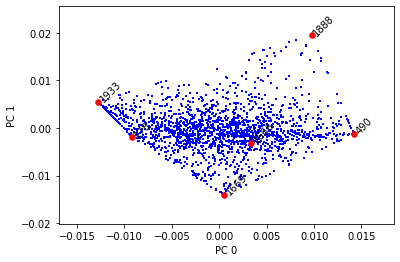

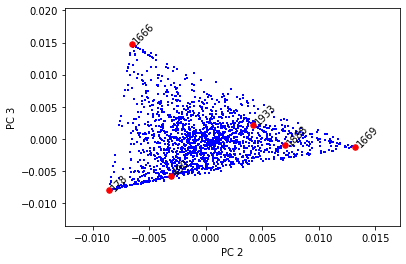

In [5]:
vis_extremal_pca(pca_proj(Cbar), S0.astype(int), [0, 1], annotate=True, fontsize=10)
vis_extremal_pca(pca_proj(Cbar), S0.astype(int), [2, 3], annotate=True, fontsize=10)

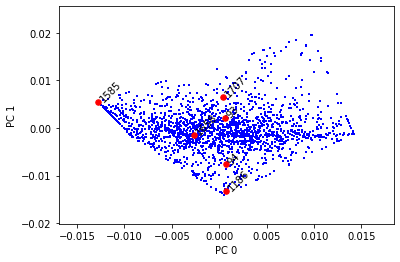

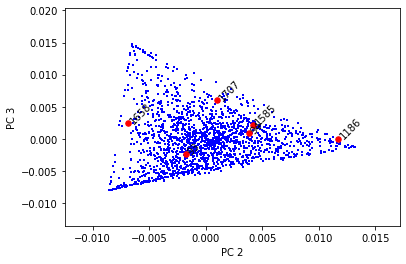

In [6]:
vis_extremal_pca(pca_proj(Cbar), S2.astype(int), [0, 1], annotate=True, fontsize=10)
vis_extremal_pca(pca_proj(Cbar), S2.astype(int), [2, 3], annotate=True, fontsize=10)

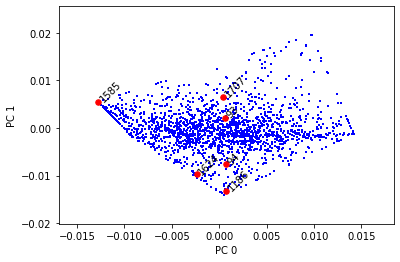

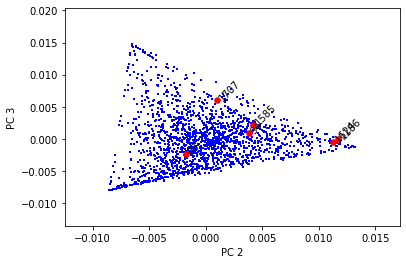

In [7]:
vis_extremal_pca(pca_proj(Cbar), S_.astype(int), [0, 1], annotate=True, fontsize=10)
vis_extremal_pca(pca_proj(Cbar), S_.astype(int), [2, 3], annotate=True, fontsize=10)

### Comment:

* Not working well. First step fails!
* Next look at the variance of $\widehat{\sum_l \hat{\bar{C}}_{jl}^2}$

## Investigate 1st step

In [8]:
# ## input: L, F, s, idx
# n_sample = 1000
# empirical = np.zeros((p, n_sample))
# corre = np.zeros((p, n_sample))
# for i in range(n_sample):
#     X = simulate_multinomial_counts_local(L, F, 2*s)
#     if X.sum(axis = 0).min() < 1:
#         pass
#     C_ = compute_C_unbiased_local(X)
#     Cbar_ = C_ / C_.sum(axis = 1)[:, None]
#     const = X.sum(axis = 1)
#     const = (1 / (const * (const - 1))).sum() / (n**2)
#     empirical[:, i] = (Cbar_**2).sum(axis = 1) 
#     corre[:, i] = correction(C = C_, u = None, const = const)
    
# outputfile="findK-exper.pkl"
# with open(outputfile, "wb") as f:
#     pickle.dump({'empirical':empirical, 'corre':corre, 'C':C, 'S0':S0}, f)

outputfile="findK-exper.pkl"
with open(outputfile, "rb") as f:
    tmp = pickle.load(f)

empirical = tmp['empirical']
corre = tmp['corre']

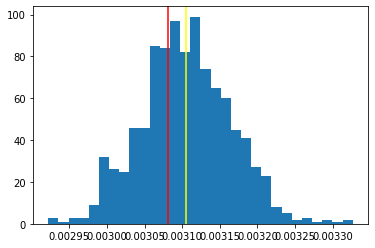

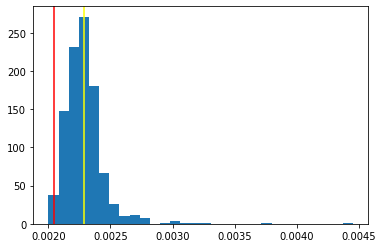

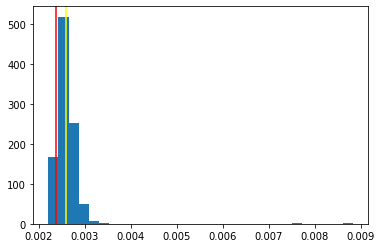

In [9]:
i_ = [1669, 1514, 94] ## first is true S0[0]; others are picked by algo in simulation
truth = (Cbar**2).sum(axis = 1)

for w in i_:
    plt.hist(empirical[w,:], bins = 30)
    #plt.xlim((0, np.quantile(empirical[w,:], 0.99)))
    plt.axvline(x=truth[w], color = "red")
    plt.axvline(x=empirical[w,:].mean(), color = "yellow")
    plt.show()

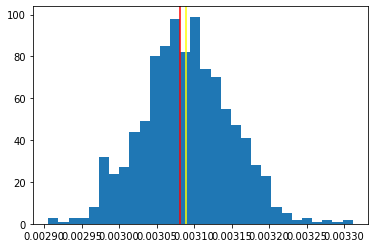

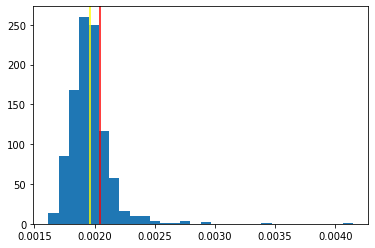

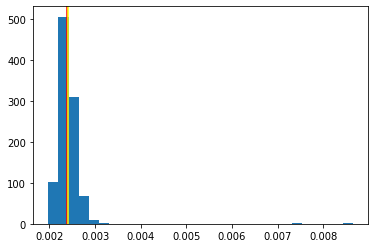

In [10]:
for w in i_:     
    plt.hist(empirical[w,:] - corre[w,:], bins = 30)
    plt.axvline(x=truth[w], color = "red")
    plt.axvline(x=(empirical[w,:] - corre[w,:]).mean(), color = "yellow")
    plt.show()

### Comment:

* Correction step definitely helps removes bias. 
* But variances are very different and we need to account for that! Look above. The true 1st anchor word has much smaller variance than the other "pseudo-" anchor words! 

TODO: derive variance for $\widehat{\sum_l \hat{\bar{C}}_{jl}^2}$ and do some shrinkage!